In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection, datasets
import numpy as np
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import xgboost

C:\Users\mvideo\Snapshots\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
book_data = pd.read_csv('book.csv')
book_data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,2045,1678,367,164,184,126,70,-22,59.95,63.66,75
1,1928,1508,420,182,221,92,63,-22,58.40,62.17,46
2,2099,1825,274,152,216,90,62,-22,58.10,62.05,-66
3,2530,2087,443,199,195,100,82,-24,56.43,60.42,67
4,2417,1915,502,195,252,87,54,-24,57.17,63.09,88


In [3]:
book_data = book_data.dropna()

In [4]:
X = np.array(book_data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']].values)
y = np.array(book_data.y.values)


**Отмасштабируем столбцы матрицы *X*, вычтя из каждого значения среднее по соответствующему столбцу и поделив результат на стандартное отклонение.**

In [5]:
means, stds = np.mean(X, axis=0), np.std(X, axis=0)

In [6]:

for i in range (X.shape[0]):
    for j in range (X.shape[1]):
        X[i, j] = (X[i, j] - means[j])/stds[j]

**Напишем функцию mserror - среднеквадратичную ошибку прогноза. Она принимает два аргумента - y (значения целевого признака) и y_pred (предсказанные значения). **

In [7]:
def mserror(y, y_pred):
    s = 0
    for i in range(len(y)):
        s += (y_pred[i] - y[i]) ** 2
    return s/y.shape[0]

In [8]:
X0, X0_test, y0, y0_test = model_selection.train_test_split(X, y, test_size = 0.3)

## Линейная регрессия

Линейная регрессия - один из наиболее хорошо изученных методов машинного обучения, позволяющий прогнозировать значения количественного признака в виде линейной комбинации прочих признаков с параметрами - весами модели. Оптимальные (в смысле минимальности некоторого функционала ошибки) параметры линейной регрессии можно найти аналитически с помощью нормального уравнения или численно с помощью методов оптимизации.


Линейная регрессия использует простой функционал качества - среднеквадратичную ошибку. Мы будем работать с выборкой, содержащей 10 признаков. Для настройки параметров (весов) модели решается следующая задача:
$$\Large \frac{1}{\ell}\sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} + ... +  w_10x_{i10}) - y_i)}^2} \rightarrow \min_{w_0, w_1, w_2...w_(10)},$$
где $x_{i1}, x_{i2}...x_{i10}$ - значения признаков $i$-го объекта, $y_i$ - значение целевого признака $i$-го объекта, $\ell$ - число объектов в обучающей выборке.

### Нормальное уравнение 
Нахождение вектора оптимальных весов $w$ может быть сделано и аналитически.
Мы хотим найти такой вектор весов $w$, чтобы вектор $y$, приближающий целевой признак, получался умножением матрицы $X$ (состоящей из всех признаков объектов обучающей выборки, кроме целевого) на вектор весов $w$. То есть, чтобы выполнялось матричное уравнение:
$$\Large y = Xw$$
Домножением слева на $X^T$ получаем:
$$\Large X^Ty = X^TXw$$
Это хорошо, поскольку теперь матрица $X^TX$ - квадратная, и можно найти решение (вектор $w$) в виде:
$$\Large w = {(X^TX)}^{-1}X^Ty$$
Матрица ${(X^TX)}^{-1}X^T$ - [*псевдообратная*](https://ru.wikipedia.org/wiki/Псевдообратная_матрица) для матрицы $X$. В NumPy такую матрицу можно вычислить с помощью функции [numpy.linalg.pinv](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.pinv.html).

Однако, нахождение псевдообратной матрицы - операция вычислительно сложная и нестабильная в случае малого определителя матрицы $X$ (проблема мультиколлинеарности). 
На практике лучше находить вектор весов $w$ решением матричного уравнения 
$$\Large X^TXw = X^Ty$$Это может быть сделано с помощью функции [numpy.linalg.solve](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linalg.solve.html).

Но все же на практике для больших матриц $X$ быстрее работает градиентный спуск, особенно его стохастическая версия.


**Добавим к матрице X столбец из единиц, используя методы hstack, ones и reshape библиотеки NumPy. Вектор из единиц нужен для того, чтобы не обрабатывать отдельно коэффициент  w0
  линейной регрессии.**

In [9]:
a = np.ones(X0.shape[0])
b = a.reshape(X0.shape[0], 1)
X1 = np.hstack((b, X0))

In [10]:
c = np.ones(X0_test.shape[0])
d = c.reshape(X0_test.shape[0], 1)
X1_test = np.hstack((d, X0_test))


**Реализуем функцию *normal_equation*, которая по заданным матрицам (массивам NumPy) *X* и *y* вычисляет вектор весов $w$ согласно нормальному уравнению линейной регрессии.**

In [11]:
def normal_equation(X, y):
    return np.dot(np.linalg.pinv(X), y)

In [12]:
norm_eq_weights = normal_equation(X1, y0)

**Напишем функцию linear_prediction, которая принимает на вход матрицу X и вектор весов линейной модели w, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы X с весами w.**

In [13]:
def linear_prediction(X, w):
    y = np.array([0.] * X.shape[0])
    for i in range (X.shape[0]):
        y[i] = X[i, 0] * w[0] + X[i, 1] * w[1] + X[i, 2] * w[2] + X[i, 3] * w[3] + X[i, 4] * w[4] + X[i, 5] * w[5] + X[i, 6] * w[6] + X[i, 7] * w[7] + X[i, 8] * w[8] + X[i, 9] * w[9] + X[i, 10] * w[10]
    return y

In [14]:
y1 = linear_prediction(X1_test, norm_eq_weights)

In [15]:
answer1 = mserror(y0_test, y1)

In [16]:
means2, stds2 = np.mean(X0, axis=0), np.std(X0, axis=0)

In [17]:
model2 = GaussianNB()
model2.fit(X0, y0)

GaussianNB(priors=None)

In [18]:
y2 = model2.predict(X0_test)

In [19]:
answer2 = mserror(y0_test, y2)

In [20]:
model3 = Sequential()
model3.add(Dense(128, activation='relu', input_shape=(X0.shape[1],)))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [21]:
model3.fit(X0, y0, epochs=1000, batch_size=5, verbose=0)

In [22]:
y3 = model3.predict(X0_test)

In [23]:
y3 = y3.reshape(len(y3),)

In [24]:
answer3 = mserror(y0_test, y3)

In [25]:
model4 = xgboost.XGBClassifier(n_estimators=100)
model4.fit(X0, y0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [26]:
y4 = model4.predict(X0_test)

C:\Users\mvideo\Snapshots\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
answer4 = mserror(y0_test, y4)

In [28]:
S1 = pd.Series(y0_test)
S1_pred = pd.Series(y1)
S2_pred = pd.Series(y2)
S3_pred = pd.Series(y3)
S4_pred = pd.Series(y4)
D = pd.DataFrame({'Реальные данные': S1, 'Линейная регрессия': S1_pred, 'Наивный байесовский алгоритм': S2_pred, 'TensorFlow': S3_pred, 'Xgboost': S4_pred})

In [29]:
D

,TensorFlow,Xgboost,Линейная регрессия,Наивный байесовский алгоритм,Реальные данные
0,169.829071,-66,159.413746,154,158
1,71.017082,-66,62.609127,63,63
2,119.560646,-66,149.674479,154,150
3,49.418922,-66,69.322030,60,69
4,207.903137,-66,140.258388,125,142
5,114.594856,-66,148.823062,103,147
6,-26.313738,-66,46.952522,-66,46
7,161.164337,-66,146.313510,186,144
8,110.932571,-66,131.117598,154,130
9,59.918991,-66,67.218873,88,67


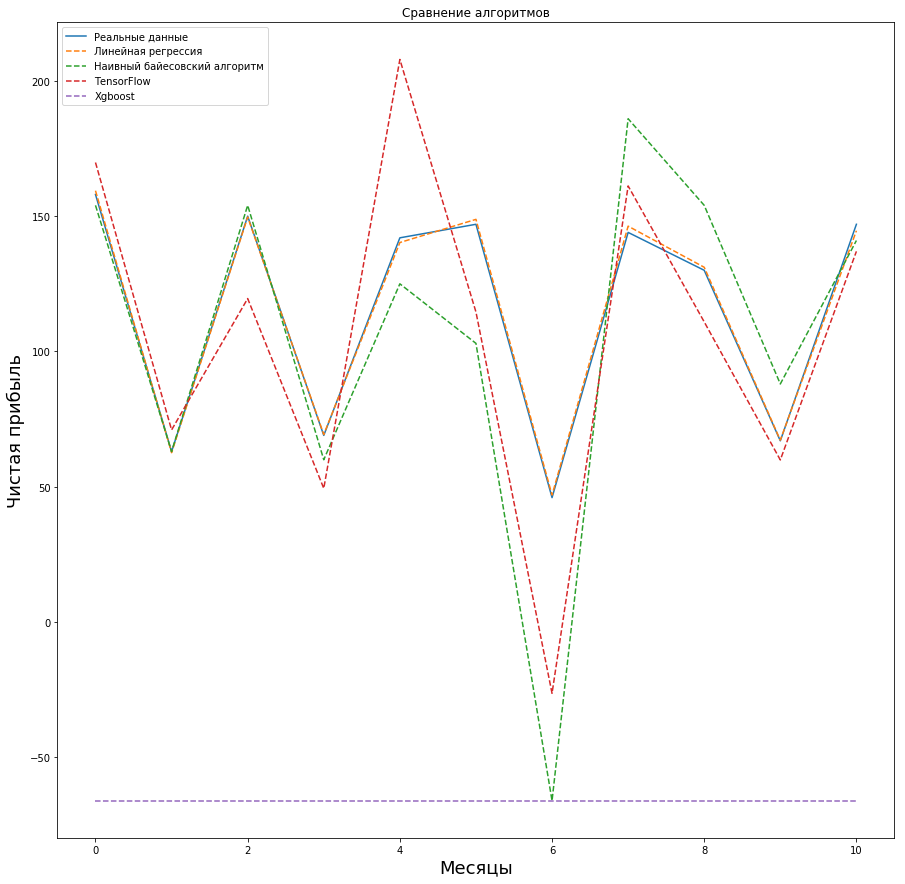

In [30]:
x = np.arange(y0_test.shape[0])
plt.rcParams["figure.figsize"] = (15,15)
fig, ax = plt.subplots()
ax.plot(x, y0_test, label='Реальные данные')
ax.plot(x, y1, '--', label='Линейная регрессия')
ax.plot(x, y2, '--', label='Наивный байесовский алгоритм')
ax.plot(x, y3, '--', label='TensorFlow')
ax.plot(x, y4, '--', label='Xgboost')
ax.set_xlabel('Месяцы', fontsize=18)
ax.set_ylabel('Чистая прибыль', fontsize=18)
ax.set_title('Сравнение алгоритмов')
ax.legend(loc=2); # upper left corner

In [31]:
print('Среднеквадратичная ошибка прогноза:')

In [32]:
S1_er = pd.Series(answer1)
S2_er = pd.Series(answer2)
S3_er = pd.Series(answer3)
S4_er = pd.Series(answer4)
Der = pd.DataFrame({'Линейная регрессия': S1_er, 'Наивный байесовский алгоритм': S2_er, 'TensorFlow': S3_er, 'Xgboost': S4_er})

Среднеквадратичная ошибка прогноза:


In [33]:
Der

,TensorFlow,Xgboost,Линейная регрессия,Наивный байесовский алгоритм
0,1176.83631,34404.454545,1.992638,1609.0


In [34]:
print('Веса для линейной регрессии:')

Веса для линейной регрессии:


In [35]:
w = norm_eq_weights

In [36]:
print("%.2f + %.2f*X1 + %.2f*X2 + %.2f*X3 + %.2f*X4 + %.2f*X5 + %.2f*X6 + %.2f*X7 + %.2f*X8 + %.2f*X9 + %.2f*X10" % (w[0], w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10]))

116.51 + 77.24*X1 + -111.29*X2 + 198.00*X3 + -266.86*X4 + -38.98*X5 + 29.05*X6 + -17.36*X7 + 0.02*X8 + -0.62*X9 + -0.21*X10


In [37]:
print('Введите данные для прогноза:')

Введите данные для прогноза:


In [38]:
p1 = float(input('X1: '))
p2 = float(input('X2: '))
p3 = float(input('X3: '))
p4 = float(input('X4: '))
p5 = float(input('X5: '))
p6 = float(input('X6: '))
p7 = float(input('X7: '))
p8 = float(input('X8: '))
p9 = float(input('X9: '))
p10 = float(input('X10: '))

X1: 


ValueError: could not convert string to float: 

In [ ]:
prog = np.array([p1, p2, p3, p4, p5, p6, p7, p8, p9, p10])

In [ ]:
for i in range (prog.shape[0]):
    prog[i] = (prog[i] - means[i])/stds[i]

In [445]:
prog0 = np.array([prog])

In [446]:
def linear_prediction2(X, w):
    y = np.array([0.])
    print(y)
    y = w[0] + X[0] * w[1] + X[1] * w[2] + X[2] * w[3] + X[3] * w[4] + X[4] * w[5] + X[5] * w[6] + X[6] * w[7] + X[7] * w[8] + X[8] * w[9] + X[9] * w[10]
    return y

In [447]:
prog1 = linear_prediction2(prog, norm_eq_weights)
prog2 = model2.predict([prog])
prog3 = model3.predict(prog0)
prog4 = model4.predict([prog])

[ 0.]


In [448]:
print('Прогноз чистой прибыли:')

Прогноз чистой прибыли:


In [449]:
S1_prog = pd.Series(prog1)
S2_prog = pd.Series(prog2)
S3_prog = pd.Series(prog3[0])
S4_prog = pd.Series(prog4)
D2 = pd.DataFrame({'Линейная регрессия': S1_prog, 'Наивный байесовский алгоритм': S2_prog, 'TensorFlow': S3_prog, 'Xgboost': S4_prog})

In [450]:
D2

,TensorFlow,Xgboost,Линейная регрессия,Наивный байесовский алгоритм
0,99.34536,78.0,-1.33044,147.0


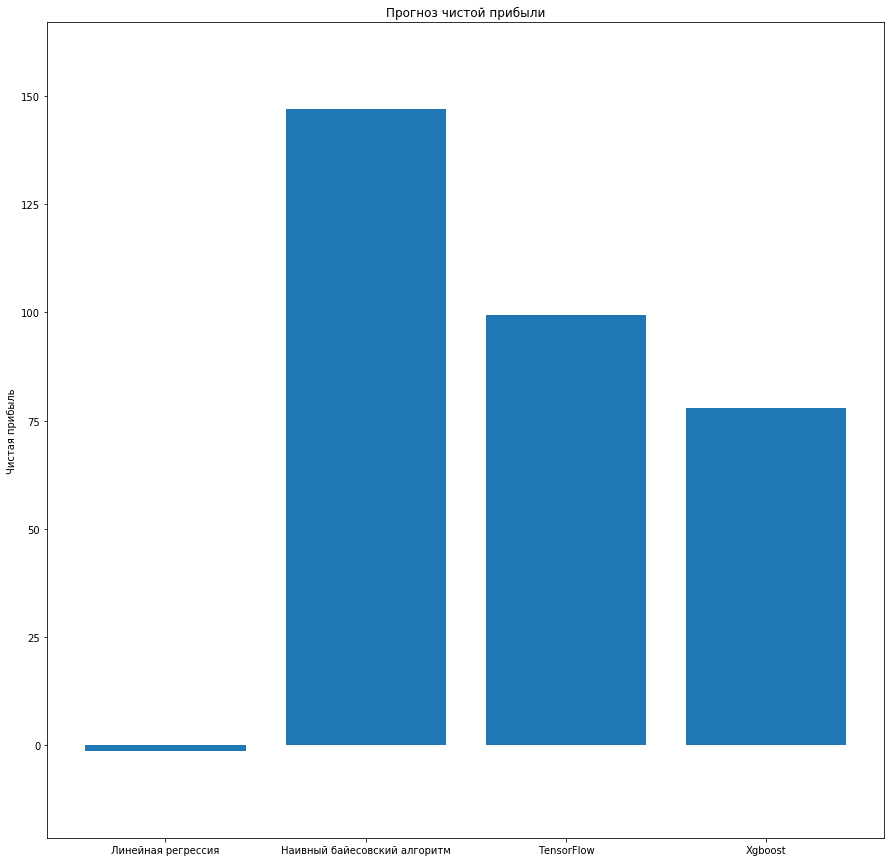

In [451]:
progs = [S1_prog[0], S2_prog[0], S3_prog[0], S4_prog[0]]
fig, ax = plt.subplots()
ind = np.arange(1, 5)
pm, pc, pn, pb = plt.bar(ind, progs)

ax.set_xticks(ind)
ax.set_xticklabels(['Линейная регрессия', 'Наивный байесовский алгоритм', 'TensorFlow', 'Xgboost'])
ax.set_ylim([min(progs) - 20, max(progs) + 20])
ax.set_ylabel('Чистая прибыль')
ax.set_title('Прогноз чистой прибыли')

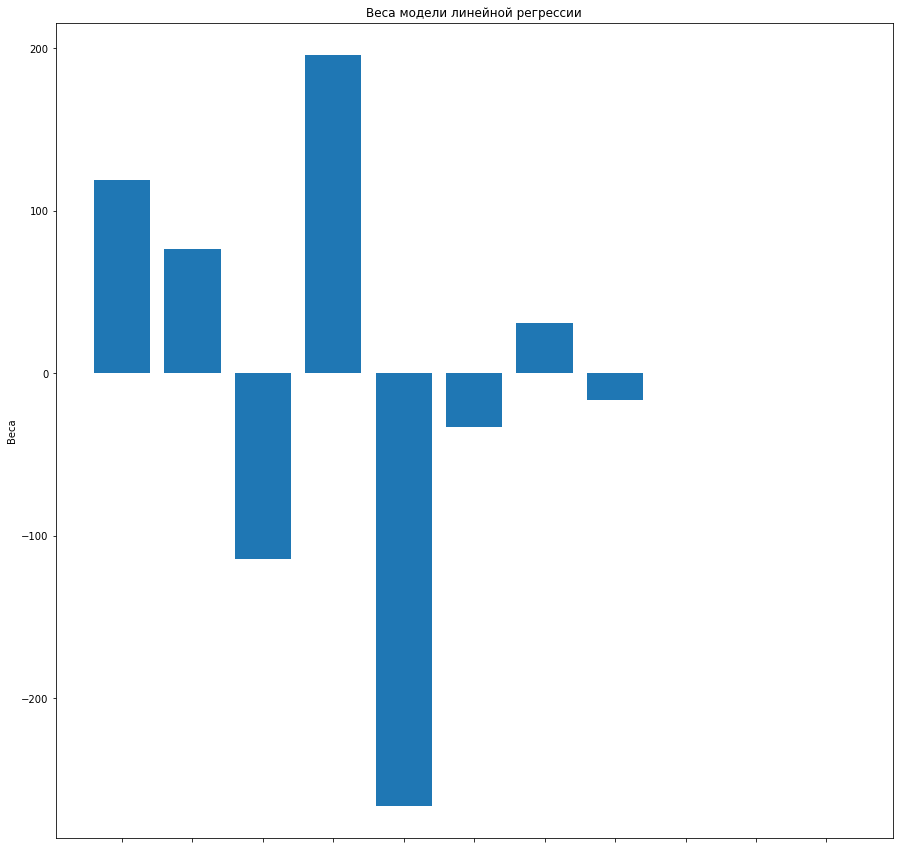

In [452]:
w = norm_eq_weights
ws = [w[0], w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9], w[10]]
fig, ax = plt.subplots()
ind = np.arange(1, len(ws) + 1)
w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 = plt.bar(ind, ws)

ax.set_xticks(ind)
ax.set_xticklabels(['', '', '', ''])
ax.set_ylim([min(norm_eq_weights) - 20, max(norm_eq_weights) + 20])
ax.set_ylabel('Веса')
ax.set_title('Веса модели линейной регрессии')

In [453]:
norm_eq_weights

array([  1.19314286e+02,   7.63009876e+01,  -1.14401399e+02,
         1.95744065e+02,  -2.66055777e+02,  -3.29211798e+01,
         3.09916908e+01,  -1.62436550e+01,  -1.27897692e-13,
        -2.84217094e-14,  -9.94759830e-14])